**Important information**

- Task involves 2 datasets from Portugese banking institution assessing if clients would subscribe to a bank term deposit.

- Phone conversations were recorded sometimes with the same person contacted multiple times.

- Common feature of both datasets is customer_id, unique number assigned to each customer.

**Objectives (first thoughts)**
- Predict the takeup of the bank term deposits from customers (Classification task - Logistic Regression, Perceptron)
- Cluster customers into groups (Sci-kit make_classification)
- Identify how bank could improve take up of the offer (Interpret the clusters and market campaigns towards target groups, PCA)
- Any other insights (Interpret matrix scores for classifiers - precision, recall, accuracy, F1)

First lets import libraries and load in the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
maindata=pd.read_csv('/content/drive/My Drive/FCA/FCA Main Data.csv')
priorcampaigndata=pd.read_csv('/content/drive/My Drive/FCA/FCA prior campaigns data.csv')

In [ ]:
maindata=maindata.dropna(how='all')
maindata=maindata.reset_index(drop=True)
maindata

,cust_id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,15139.0,27.0,student,single,university.degree,no,unknown,unknown,cellular,jul,thu,312.0,1.0,1.4,93.918,-42.7,4.958,5228.1,no
1,32927.0,49.0,blue-collar,married,basic.9y,unknown,no,yes,cellular,may,mon,290.0,1.0,-1.8,92.893,-46.2,1.299,5099.1,no
2,26145.0,29.0,services,married,basic.6y,no,no,no,cellular,nov,wed,314.0,2.0,-0.1,93.200,-42.0,4.120,5195.8,no
3,11224.0,31.0,blue-collar,married,basic.9y,no,no,no,telephone,jun,thu,217.0,2.0,1.4,94.465,-41.8,4.961,5228.1,no
4,35458.0,36.0,admin.,single,unknown,no,yes,no,cellular,may,mon,222.0,6.0,-1.8,92.893,-46.2,1.244,5099.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,11155.0,53.0,admin.,single,high.school,no,no,no,telephone,jun,thu,223.0,1.0,1.4,94.465,-41.8,4.961,5228.1,no
41184,18906.0,46.0,blue-collar,married,basic.9y,no,no,no,cellular,aug,mon,488.0,2.0,1.4,93.444,-36.1,4.970,5228.1,no
41185,21688.0,33.0,technician,single,university.degree,no,no,no,cellular,aug,tue,302.0,3.0,1.4,93.444,-36.1,4.963,5228.1,no
41186,13817.0,40.0,technician,married,university.degree,no,yes,no,cellular,jul,thu,296.0,3.0,1.4,93.918,-42.7,4.963,5228.1,no


In [ ]:
newdata=maindata["cust_id"].drop_duplicates()
newdata.shape

(41188,)

In [ ]:
priorcampaigndata=priorcampaigndata.dropna(how='all')
priorcampaigndata=priorcampaigndata.reset_index(drop=True)
priorcampaigndata['pdays']=priorcampaigndata['pdays'].replace(np.nan,999)
priorcampaigndata['previous']=priorcampaigndata['previous'].replace(np.nan,0)
priorcampaigndata['poutcome']=priorcampaigndata['poutcome'].replace(np.nan,'inconclusive')
priorcampaigndata

,cust_id,pdays,previous,poutcome
0,25391.0,999.0,0.0,inconclusive
1,3686.0,999.0,0.0,inconclusive
2,31762.0,999.0,0.0,inconclusive
3,19809.0,999.0,0.0,inconclusive
4,25365.0,999.0,0.0,inconclusive
...,...,...,...,...
41173,4130.0,999.0,0.0,inconclusive
41174,32027.0,999.0,0.0,inconclusive
41175,19016.0,999.0,0.0,inconclusive
41176,28920.0,999.0,0.0,inconclusive


In [ ]:
priorcampaigndata1=priorcampaigndata.dropna(how='any')
priorcampaigndata=priorcampaigndata.reset_index(drop=True)
priorcampaigndata1

,cust_id,pdays,previous,poutcome
0,25391.0,999.0,0.0,inconclusive
1,3686.0,999.0,0.0,inconclusive
2,31762.0,999.0,0.0,inconclusive
3,19809.0,999.0,0.0,inconclusive
4,25365.0,999.0,0.0,inconclusive
...,...,...,...,...
41173,4130.0,999.0,0.0,inconclusive
41174,32027.0,999.0,0.0,inconclusive
41175,19016.0,999.0,0.0,inconclusive
41176,28920.0,999.0,0.0,inconclusive


In [ ]:
totaldata=maindata.merge(priorcampaigndata[["cust_id","pdays","previous","poutcome"]])
totaldata

,cust_id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed,pdays,previous,poutcome
0,15139.0,27.0,student,single,university.degree,no,unknown,unknown,cellular,jul,thu,312.0,1.0,1.4,93.918,-42.7,4.958,5228.1,no,999.0,0.0,inconclusive
1,32927.0,49.0,blue-collar,married,basic.9y,unknown,no,yes,cellular,may,mon,290.0,1.0,-1.8,92.893,-46.2,1.299,5099.1,no,999.0,0.0,inconclusive
2,26145.0,29.0,services,married,basic.6y,no,no,no,cellular,nov,wed,314.0,2.0,-0.1,93.200,-42.0,4.120,5195.8,no,999.0,0.0,inconclusive
3,11224.0,31.0,blue-collar,married,basic.9y,no,no,no,telephone,jun,thu,217.0,2.0,1.4,94.465,-41.8,4.961,5228.1,no,999.0,0.0,inconclusive
4,35458.0,36.0,admin.,single,unknown,no,yes,no,cellular,may,mon,222.0,6.0,-1.8,92.893,-46.2,1.244,5099.1,no,999.0,0.0,inconclusive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41173,11155.0,53.0,admin.,single,high.school,no,no,no,telephone,jun,thu,223.0,1.0,1.4,94.465,-41.8,4.961,5228.1,no,999.0,0.0,inconclusive
41174,18906.0,46.0,blue-collar,married,basic.9y,no,no,no,cellular,aug,mon,488.0,2.0,1.4,93.444,-36.1,4.970,5228.1,no,999.0,0.0,inconclusive
41175,21688.0,33.0,technician,single,university.degree,no,no,no,cellular,aug,tue,302.0,3.0,1.4,93.444,-36.1,4.963,5228.1,no,999.0,0.0,inconclusive
41176,13817.0,40.0,technician,married,university.degree,no,yes,no,cellular,jul,thu,296.0,3.0,1.4,93.918,-42.7,4.963,5228.1,no,999.0,0.0,inconclusive


For our total data there are 22 feature categories.
41,178 phone calls were used to collect data on categories.
our dependent feature is 'subscribed'. We can see that some of the categories e.g. 'default' contain values 'unknown'. much of the phone calls from the prior campaigns resulted in no data and return NaN. Knowing that some people may have been contacted twice we must check this and remove any duplicates.

In [ ]:
totaldata=totaldata.drop_duplicates()
totaldata.shape

(41178, 22)

It appears as though there were no duplicate entries, even though some customers may have been contacted twice the information provided was not the same. Lets check the spread of our dependent variable 'subscribed'.

In [ ]:
print(totaldata["subscribed"].value_counts())
print(totaldata["subscribed"].value_counts()/len(totaldata.subscribed))

no     36538
yes     4640
Name: subscribed, dtype: int64
no     0.887318
yes    0.112682
Name: subscribed, dtype: float64


The first thing to note is that we have 88% of people have not subscribed. As our task is a classification task and we have an extremely unbalanced dataset we can instantly assume accuracy will not be an appropriate metric for our models to follow.

lets plot some charts to visualise all of our features and how they are related to our dependent variable.

In [ ]:
class UnderstandingData:
    
    def __init__(self, raw_df):
        self.raw_df = raw_df
        self.raw_df_grouped = raw_df.groupby("subscribed")
        self.class_name_no = "no"
        self.class_name_yes = "yes"
        self.raw_df_grouped_no = self.raw_df_grouped.get_group(self.class_name_no)
        self.raw_df_grouped_yes = self.raw_df_grouped.get_group(self.class_name_yes)

    def plot_histogram_continuous(self, feature_name, bin_size):
        plt.figure()
        plt.hist(self.raw_df_grouped_no[feature_name], bins=bin_size, label=self.class_name_no)
        plt.hist(self.raw_df_grouped_yes[feature_name], bins=bin_size, label=self.class_name_yes)
        plt.legend()
        plt.title("Feature Histogram - "+feature_name)
        plt.xlabel("Feature values")
        plt.ylabel("Count")

    def plot_histogram_categorical(self, feature_name):
        feature_df = pd.DataFrame()
        feature_df["no"] = self.raw_df_grouped_no[feature_name].value_counts()
        feature_df["yes"] = self.raw_df_grouped_yes[feature_name].value_counts()
        
        feature_df.plot(kind='bar')
        plt.title("Feature Histogram - "+feature_name)
        plt.ylabel("Count")
        plt.xlabel("Feature unique values")
        plt.tight_layout()

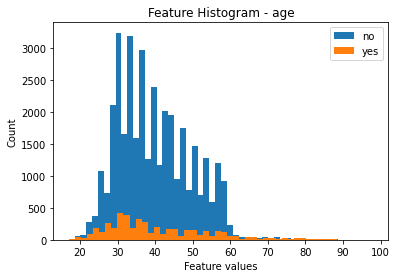

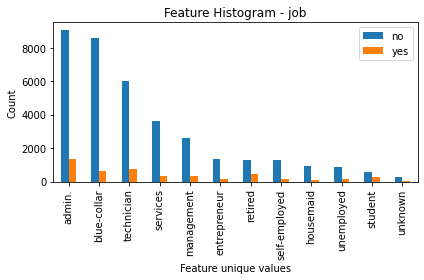

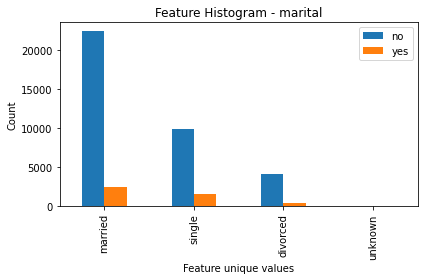

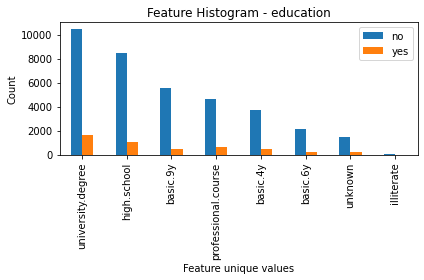

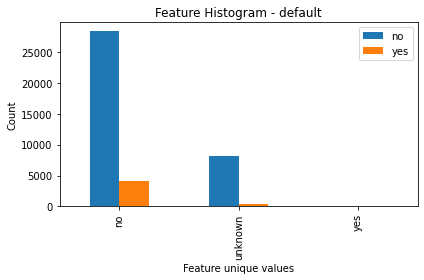

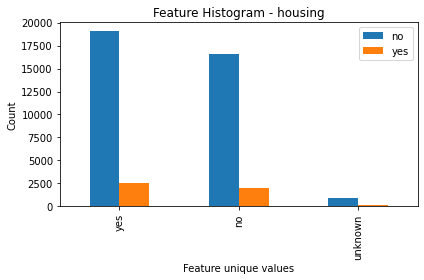

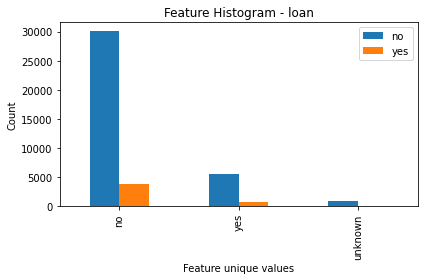

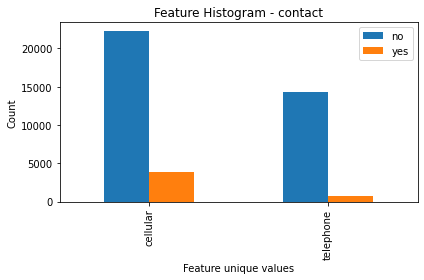

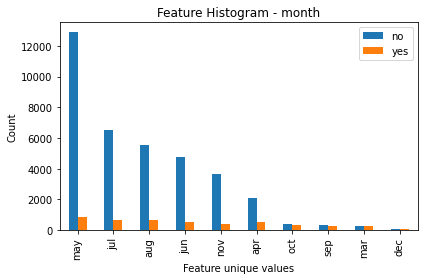

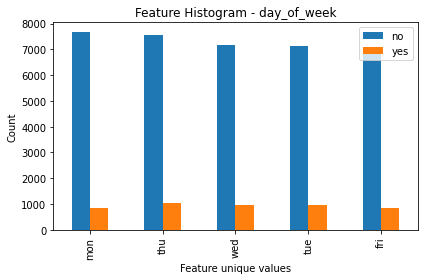

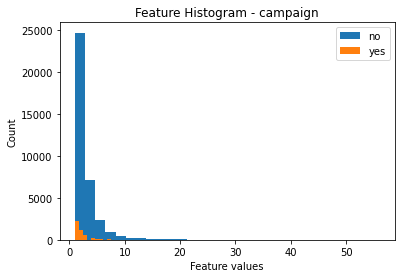

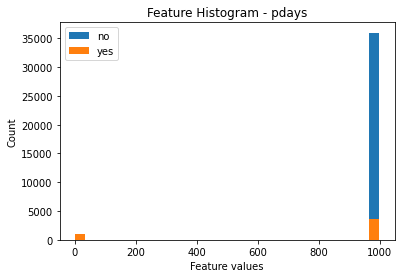

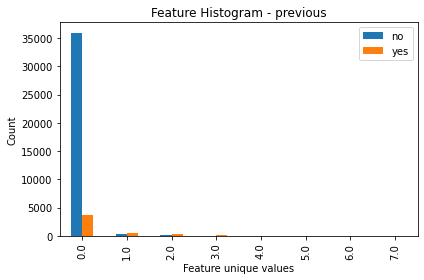

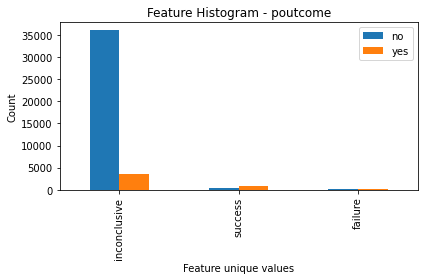

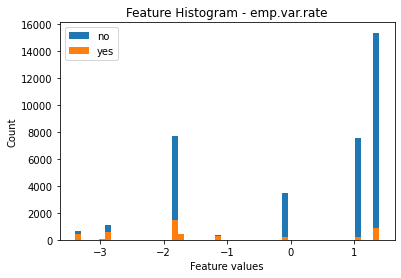

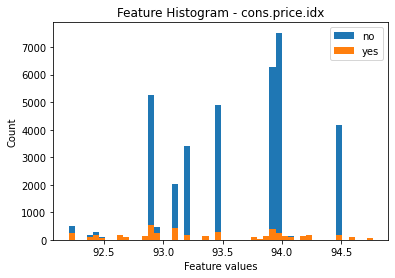

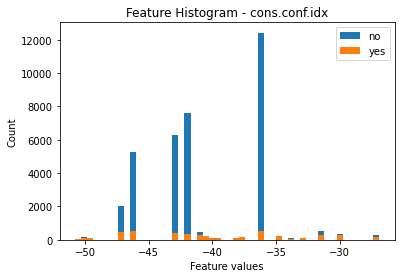

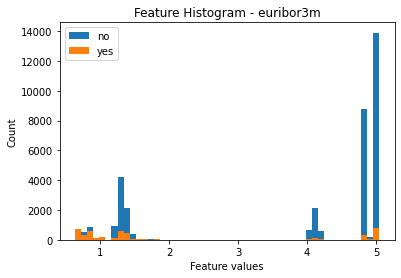

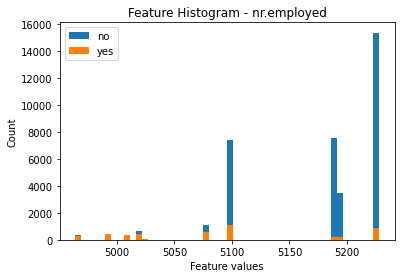

In [ ]:
understanding_data = UnderstandingData(totaldata)

understanding_data.plot_histogram_continuous("age",50)

understanding_data.plot_histogram_categorical("job")

understanding_data.plot_histogram_categorical("marital")

understanding_data.plot_histogram_categorical("education")

understanding_data.plot_histogram_categorical("default")

understanding_data.plot_histogram_categorical("housing")

understanding_data.plot_histogram_categorical("loan")

understanding_data.plot_histogram_categorical("contact")

understanding_data.plot_histogram_categorical("month")

understanding_data.plot_histogram_categorical("day_of_week")

understanding_data.plot_histogram_continuous("campaign", 30)

understanding_data.plot_histogram_continuous("pdays", 30)

understanding_data.plot_histogram_categorical("previous")

understanding_data.plot_histogram_categorical("poutcome")

understanding_data.plot_histogram_continuous("emp.var.rate", 50)

understanding_data.plot_histogram_continuous("cons.price.idx", 50)

understanding_data.plot_histogram_continuous("cons.conf.idx", 50)

understanding_data.plot_histogram_continuous("euribor3m", 50)

understanding_data.plot_histogram_continuous("nr.employed", 50)

In [ ]:
totaldata.dtypes

cust_id           float64
age               float64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration          float64
campaign          float64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
subscribed         object
pdays             float64
previous          float64
poutcome           object
dtype: object

In [ ]:
totaldata.isna().sum()

cust_id           0
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
subscribed        0
pdays             0
previous          0
poutcome          0
dtype: int64

There are no Null values so we do not need to impute. 11/22 categories are object types that must be converted into numerical to be used with machine learning models. First we need to check which categories contained unknown values and fill these in.

In [ ]:
totaldata.replace('unknown',np.NaN,inplace=True)
totaldata.isna().sum()

cust_id              0
age                  0
job                330
marital             80
education         1730
default           8596
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
subscribed           0
pdays                0
previous             0
poutcome             0
dtype: int64

We can see now that 5 of the columns from maindata contained unknown values. These can be filled using a Decision Tree. To fill the main data first we create a function that will convert categories for all of the object features into numerical using astype.cat.codes. They we use function fillUnknown to specify what columns we want to convert. Unknown values are represented as 0 which are converted using a decision tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def makeCategories(dataframe,columns):
  for column in columns:
    dataframe[column] = dataframe[column].astype("category").cat.codes
  return dataframe

def fillUnknown(dataframe, missingColumns):
  dataframe1=dataframe.copy()
  for column in missingColumns:
    dataframe1=makeCategories(dataframe1,["job","marital","education","default","housing","loan","contact","month","day_of_week","subscribed","poutcome"])
    tree=DecisionTreeClassifier()
    test=dataframe1[dataframe1[column]==0]#test is data 'unknown'
    train=dataframe1[dataframe1[column]!=0]#train is all other values
    tree.fit(train.drop(column,axis=1),train[column])
    test.loc[:,column]=tree.predict(test.drop(column,axis=1))
    dataframe1=train.append(test)
    dataframe.replace(0,np.NaN,inplace=True)
  
  return dataframe1

In [ ]:
totaldata1=fillUnknown(totaldata.copy(),["job","marital","education","default","housing","loan"])
print(totaldata1)
totaldata1.dtypes

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

       cust_id   age  job  marital  ...  subscribed  pdays  previous  poutcome
2      26145.0  29.0    7        1  ...           0  999.0       0.0         1
3      11224.0  31.0    1        1  ...           0  999.0       0.0         1
5      29864.0  56.0    5        0  ...           0  999.0       0.0         1
6      23328.0  42.0    4        1  ...           0  999.0       0.0         1
7      17901.0  31.0    1        2  ...           0  999.0       0.0         1
...        ...   ...  ...      ...  ...         ...    ...       ...       ...
37274   7330.0  42.0    1        1  ...           0  999.0       0.0         1
38716  10924.0  51.0    1        0  ...           0  999.0       0.0         1
38752  16842.0  53.0    1        1  ...           0  999.0       0.0         1
1213   22420.0  56.0    5        1  ...           0  999.0       0.0         1
15145  10642.0  49.0    1        2  ...           0  999.0       0.0         1

[41178 rows x 22 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


cust_id           float64
age               float64
job                  int8
marital              int8
education            int8
default              int8
housing              int8
loan                 int8
contact              int8
month                int8
day_of_week          int8
duration          float64
campaign          float64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
subscribed           int8
pdays             float64
previous          float64
poutcome             int8
dtype: object

Now we have our main data such that all object features are now numerical. We need to create dummy variables for all the previous 'object' columns such that each feature becomes a binary category. These are the features marked above that now have int8 as their return value.

In [ ]:
categoryColumns = ["job","marital","education","default","housing","loan","contact","month","day_of_week","poutcome"]

for column in categoryColumns:
  totaldata1=totaldata1.join(pd.get_dummies(totaldata1[column],prefix=column),how='left',lsuffix='left',rsuffix='right')

dummyColumns=[column for column in totaldata1.columns if column not in categoryColumns]
totaldata1=totaldata1[dummyColumns]

totaldata1["subscribed"]=totaldata1.subscribed.astype("category")
totaldata1["subscribed"]=totaldata1["subscribed"].cat.codes
totaldata1.shape

(41178, 59)

We now have our processed data, 59 features that can be used to predict uptake of our dependent variable 'subscribed'. We now need to split the data into train and test.

In [ ]:
data_x=totaldata1.drop(["subscribed"],axis=1)
data_x=data_x.drop(["cust_id"],axis=1)
data_y=totaldata1["subscribed"]
print(data_x)
print(data_y)

        age  duration  campaign  ...  poutcome_0  poutcome_1  poutcome_2
2      29.0     314.0       2.0  ...           0           1           0
3      31.0     217.0       2.0  ...           0           1           0
5      56.0     529.0       3.0  ...           0           1           0
6      42.0     220.0      11.0  ...           0           1           0
7      31.0     171.0      13.0  ...           0           1           0
...     ...       ...       ...  ...         ...         ...         ...
37274  42.0     311.0       4.0  ...           0           1           0
38716  51.0     339.0       2.0  ...           0           1           0
38752  53.0     747.0       1.0  ...           0           1           0
1213   56.0     119.0       1.0  ...           0           1           0
15145  49.0     479.0       1.0  ...           0           1           0

[41178 rows x 57 columns]
2        0
3        0
5        0
6        0
7        0
        ..
37274    0
38716    0
38752    

We've dropped cus_id as it has no relationship with our dependent variable. Now we're going to create train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(data_x, data_y, test_size=0.2, random_state=0)

print("X Train", X_train.shape)
print("X Test", X_test.shape)
print("Y Train", y_train.shape)
print("Y Test", y_test.shape)

X Train (32942, 57)
X Test (8236, 57)
Y Train (32942,)
Y Test (8236,)


Now lets run our data through a logistic regression model and see what the results show. First we need to optimise our 'C' value which is our regularization term, smaller=stronger. We do this against the metric 'recall' as this is our models ability to predict correctly if a customer will subscribe to the deal.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from numpy import mean
from numpy import std

logistic_regression=LogisticRegression(max_iter=150)

grid = dict()
grid['C'] = [1, 2, 3, 4, 5]
search = GridSearchCV(logistic_regression, grid, scoring='precision', cv=5, n_jobs=-1)
results = search.fit(X_train, y_train)
print('Mean Recall: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy:  0.8566051481301603


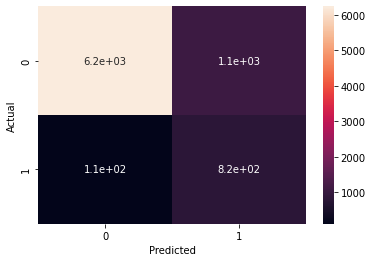

[[6240 1074]
 [ 107  815]]


In [ ]:
logistic_regression=LogisticRegression(penalty="l2",max_iter=1000,class_weight="balanced",C=5)
logistic_regression.fit(X_train,y_train)

y_pred=logistic_regression.predict(X_test)

confusion_matrix1=confusion_matrix(y_test,y_pred)
confusion_matrix2=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'],normalize=False)
sn.heatmap(confusion_matrix2,annot=True)

print('Accuracy: ', metrics.accuracy_score(y_test,y_pred))
plt.show()
print(confusion_matrix1)

In [ ]:
precision=817/(817+1074)
recall=817/(817+105)
F1=(2*precision*recall)/(precision+recall)
posPredict=(6240/(6240+1074))

print(precision)
print(recall)
print(F1)
print(posPredict)

0.43204653622422
0.886117136659436
0.5808745111980093
0.8531583264971287


Feature. 0, Score: 0.05621
Feature. 1, Score: 0.02314
Feature. 2, Score: 0.09874
Feature. 3, Score: 0.01693
Feature. 4, Score: -0.00509
Feature. 5, Score: -0.02872
Feature. 6, Score: -0.03809
Feature. 7, Score: -0.03928
Feature. 8, Score: 0.01472
Feature. 9, Score: 0.03855
Feature. 10, Score: -0.01262
Feature. 11, Score: 0.01896
Feature. 12, Score: -0.04514
Feature. 13, Score: 0.03273
Feature. 14, Score: 0.05390
Feature. 15, Score: -0.02696
Feature. 16, Score: -0.05281
Feature. 17, Score: -0.04446
Feature. 18, Score: -0.00662
Feature. 19, Score: -0.01032
Feature. 20, Score: -0.09136
Feature. 21, Score: -0.01921
Feature. 22, Score: 0.02234
Feature. 23, Score: -0.00432
Feature. 24, Score: -0.09529
Feature. 25, Score: 0.02118
Feature. 26, Score: 0.07194
Feature. 27, Score: -0.03557
Feature. 28, Score: -0.00716
Feature. 29, Score: 0.03590
Feature. 30, Score: 0.00831
Feature. 31, Score: -0.01120
Feature. 32, Score: 0.01638
Feature. 33, Score: 0.02412
Feature. 34, Score: 0.02389
Feature. 35,

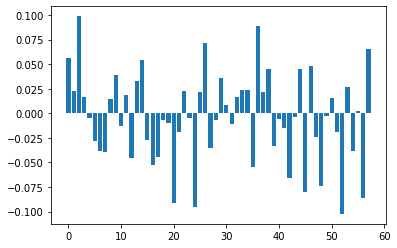

In [ ]:
from sklearn.datasets import make_classification

data_x, data_y = make_classification(n_samples=32942,n_features=58,n_informative=20,n_redundant=38,random_state=1)

model=LogisticRegression(penalty="l2",max_iter=1000,class_weight="balanced",C=5)
model.fit(data_x,data_y)
importance=model.coef_[0]
for i,v in enumerate(importance):
  print('Feature. %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import RepeatedStratifiedKFold

MLPerceptron = Perceptron(eta0=0.00001)
MLPerceptron = Perceptron(max_iter=100)
MLPerceptron.fit(X_train, y_train)

grid = dict()
grid['eta0'] = [0.00001, 0.0001, 0.001, 0.01, 0.1]
cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
search = GridSearchCV(MLPerceptron, grid, scoring='recall', cv=cv, n_jobs=-1)
results = search.fit(X_train, y_train)
print('Mean Recall: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Recall: 0.30183
Config: {'eta0': 1e-05}
>0.30183 with: {'eta0': 1e-05}
>0.29967 with: {'eta0': 0.0001}
>0.29967 with: {'eta0': 0.001}
>0.29967 with: {'eta0': 0.01}
>0.29967 with: {'eta0': 0.1}


In [ ]:
from sklearn.model_selection import cross_val_score

MLPerceptron = Perceptron(eta0=0.00001)
MLPerceptron = Perceptron(max_iter=100)
MLPerceptron.fit(X_train, y_train)

cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
scores = cross_val_score(MLPerceptron, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (np.mean(scores), np.std(scores)))

testPredictions = MLPerceptron.predict(X_test)
testPredictions = pd.DataFrame(testPredictions)


confusion_matrix1=confusion_matrix(y_test,testPredictions)

print('Accuracy: ', metrics.accuracy_score(y_test,y_pred))
print(confusion_matrix1)

Mean Accuracy: 0.85751 (0.14450)
Accuracy:  0.8566051481301603
[[7305    9]
 [ 878   44]]


In [ ]:
precision=44/(44+9)
recall=44/(44+878)
F1=(2*precision*recall)/(precision+recall)
posPredict=(7305/(7305+9))

print(precision)
print(recall)
print(F1)
print(posPredict)

0.8301886792452831
0.04772234273318872
0.09025641025641025
0.9987694831829368
